<a href="https://colab.research.google.com/github/GuilhermePelegrina/Mackenzie/blob/main/Arquivos%20Adicionais/Aula_PCP_series_temporais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<head>
  <meta name="author" content="Rogério de Oliveira">
  <meta institution="author" content="Universidade Presbiteriana Mackenzie">
</head>

<img src="http://meusite.mackenzie.br/rogerio/mackenzie_logo/UPM.2_horizontal_vermelho.jpg" width=300, align="left">
<!-- <h1 align=left><font size = 6, style="color:rgb(200,0,0)"> optional title </font></h1> -->

# **Séries Temporais com variáveis exógenas**

Nesta aula, revisaremos alguns modelos de séries temporais, como médias móveis e ARIMA, e abordaremos um novo modelo que considera variáveis exógenas. Ou seja, a variável de entrada não é somente o tempo, mas também algum atributo externo. Isso é comum em previsão de demanda, por exemplo, quando o preço do item tem um impacto relevante na previsão (além, é claro, do componente temporal).

In [ ]:
# Bibliotecas úteis para os códigos desta aula

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings("ignore")


In [ ]:
#@markdown `tspplot()`
#@markdown `tspdisplay()`

def tspplot(ts=None,label=None,title=None,ax=None,linestyle='solid',alpha=1,lw=1,nr_xticks=None,nr_yticks=None):

  import matplotlib.ticker as ticker

  if ax is None:
    fig, ax = plt.subplots()

  if label is not None:
    ax.plot(ts, label=label, linestyle=linestyle, lw=lw)
  else:
    ax.plot(ts, linestyle=linestyle,lw=lw,alpha=alpha)

  if title is not None:
    ax.set_title(title)

  if nr_xticks is not None:
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nr_xticks))

  if nr_yticks is not None:
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nr_yticks))

  if label is not None:
    plt.legend()

  plt.tight_layout()

  return


class tspdisplay(object):
    # Adaptado de https://jakevdp.github.io/PythonDataScienceHandbook/index.html
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <hr>
    <h3 style='font-family:"Courier New", Courier, monospace'>{0}</h3><hr>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args

    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a + '.head()')._repr_html_())
                         for a in self.args)

    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a + '.head()'))
                           for a in self.args)

# **Dados**

Utilizaremos os dados abaixo para construir os modelos de previsão. Nessa base de dados, temos a demanda de um determinado produto (série temporal) ao longo do tempo. Repare que as datas indicam os finais de cada mês, ou seja, as demandas são mensais. Além disso, repare que há uma coluna (`exog`) que indica uma variável exógena (ou seja, um outro dado que não seja temporal) que pode ser usada na previsão da demanda. Nos dados em questão, essa variável indica o preço do produto ao longo do tempo.

In [ ]:
# Lendo e exibindo os dados

serie = pd.read_csv("https://raw.githubusercontent.com/guilhermepelegrina/Mackenzie/main/Datasets/data_serie_temporal_exogena.csv")

# Exibindo as primeiras linhas da série gerada
serie

,data,serie_temporal,exog
0,2020-01-31,197.629173,19.536502
1,2020-02-29,201.688835,17.555514
2,2020-03-31,208.859181,17.666812
3,2020-04-30,200.737453,17.691545
4,2020-05-31,203.188758,17.871892
5,2020-06-30,208.395999,20.401931
6,2020-07-31,197.924062,18.611312
7,2020-08-31,190.365034,18.553826
8,2020-09-30,186.849092,18.803889
9,2020-10-31,189.583342,20.319079


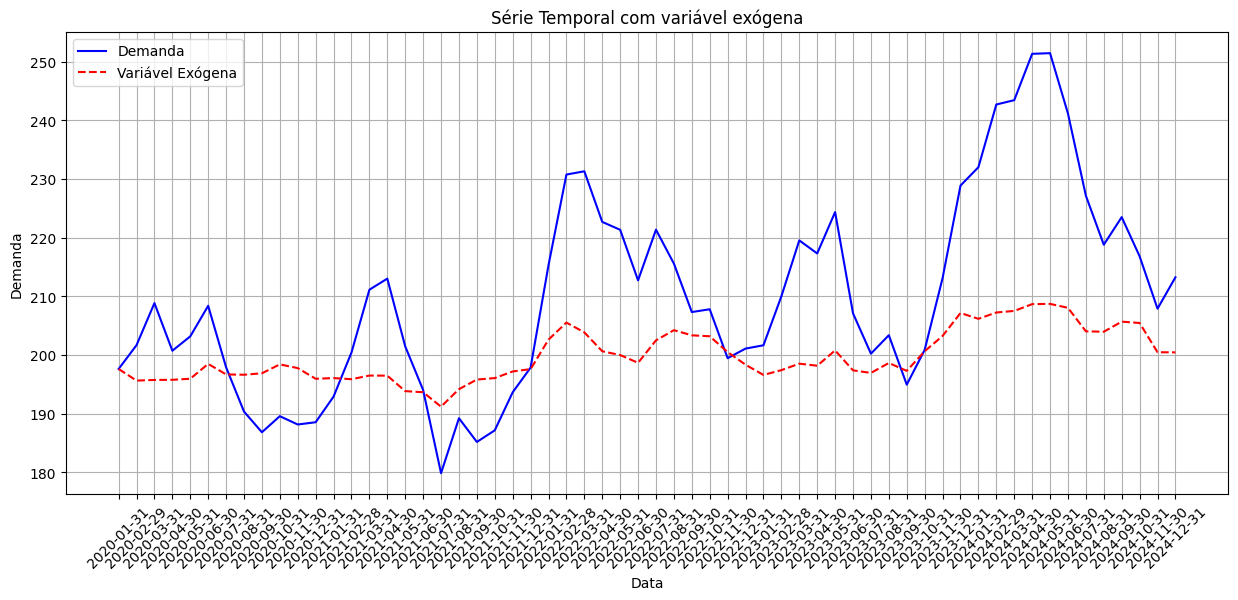

In [ ]:
# Plotando a série temporal gerada

# Aqui, normalizamos os dados da variável exógena para ficar mais fácil de visualizar

plt.figure(figsize=(15,6))
plt.plot(serie['data'], serie['serie_temporal'], label='Demanda', color='b')
plt.plot(serie['data'], serie['exog']+(serie['serie_temporal'][0]-serie['exog'][0]), label='Variável Exógena', color='r', linestyle='--')
plt.title('Série Temporal com variável exógena')
plt.xlabel('Data')
plt.ylabel('Demanda')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
serie.drop(columns=['data']).corr()

,serie_temporal,exog,mm3,mm3_atual,arima,arima_atual,arimax
serie_temporal,1.000000,0.858054,0.670882,0.920550,0.029928,0.815345,0.967429
exog,0.858054,1.000000,0.489097,0.793815,0.047051,0.791507,0.975703
mm3,0.670882,0.489097,1.000000,0.724452,-0.448504,-0.017163,0.004935
mm3_atual,0.920550,0.793815,0.724452,1.000000,-0.335342,0.895158,0.836715
arima,0.029928,0.047051,-0.448504,-0.335342,1.000000,-0.189946,0.077608
arima_atual,0.815345,0.791507,-0.017163,0.895158,-0.189946,1.000000,0.802319
arimax,0.967429,0.975703,0.004935,0.836715,0.077608,0.802319,1.000000


Essa base de dados vai desde o início de 2020 até o final de 2024. Para efeito de construção e avaliação do modelo, vamos usar os dados até o final de 2023 para treinamento e o restante para teste (avaliação).

In [ ]:
# Criando os índices dos dados de treinamento e teste

test_size = 12
train_size = len(serie) - test_size
test_size = len(serie)

train_ind = np.arange(0,train_size)
test_ind = np.arange(train_size,test_size)

# **Séries Temporais - Revisão**

Para quem já teve as aulas de TIC deste semestre (ou mesmo em PCP), deve ter visto alguns modelos de previsão. No início desta aula, faremos uma revisão (rápida) do uso de tais modelos para fazer a previsão da demanda dos dados considerados.


# Médias moveis simples

A média móvel simples consiste na média aritmética levando em conta $n$ períodos anteriores. Por exemplo, ao se considerar 3 períodos, o valor do período $i$ é dado pelo seguinte cálculo:

$$preco_i = \frac{preço_{i-1} + preço_{i-2} + preço_{i-3}}{3}$$

Com isso, então, levamos em conta um conjunto de períodos anteriores para prever o valor de um próximo período. Em Python, as médias móveis são calculadas com o comando *rolling(window=n)* e, em seguida, *mean()*.

Nos códigos abaixo aplicamos as médias móveis para fazer previsões futuras e atuais. As previsões atuais seriam as realizadas nos instantes anteriores à previsão do período seguinte. Ou seja, consideramos os valores que acorreram de fato para fazer as previsões). Sendo assim, na prática, podemos usar as previsões futuras para planejamento de longo prazo e as previsões atuais para ajustes na medida que o tempo passa.


In [ ]:
# Média móvel simples (previsão futura)

# Construindo o modelo (com os dados de treinamento)
serie['mm3'] = serie['serie_temporal'][train_ind].rolling(window=3).mean()

# Fazendo previsões
for ii in test_ind:
  serie['mm3'][ii] = (serie['mm3'][ii-1] + serie['mm3'][ii-2] + serie['mm3'][ii-3])/3

serie.tail(12)

,data,serie_temporal,exog,mm3
48,2024-01-31,232.020825,28.088544,205.675306
49,2024-02-29,242.708539,29.162857,207.653256
50,2024-03-31,243.448920,29.432240,209.208725
51,2024-04-30,251.350268,30.588865,207.512429
52,2024-05-31,251.461379,30.632811,208.124803
53,2024-06-30,241.168332,29.959645,208.281986
54,2024-07-31,227.165349,25.953775,207.973073
55,2024-08-31,218.808729,25.885237,208.126621
56,2024-09-30,223.514310,27.605160,208.127226
57,2024-10-31,216.837710,27.376560,208.075640


In [ ]:
# Média móvel simples (previsão atual)

# Construindo o modelo (com os dados de treinamento)
serie['mm3_atual'] = serie['serie_temporal'].rolling(window=3).mean()

serie.tail(12)

,data,serie_temporal,exog,mm3,mm3_atual
48,2024-01-31,232.020825,28.088544,205.675306,224.677003
49,2024-02-29,242.708539,29.162857,207.653256,234.539332
50,2024-03-31,243.448920,29.432240,209.208725,239.392761
51,2024-04-30,251.350268,30.588865,207.512429,245.835909
52,2024-05-31,251.461379,30.632811,208.124803,248.753523
53,2024-06-30,241.168332,29.959645,208.281986,247.993327
54,2024-07-31,227.165349,25.953775,207.973073,239.931687
55,2024-08-31,218.808729,25.885237,208.126621,229.047470
56,2024-09-30,223.514310,27.605160,208.127226,223.162796
57,2024-10-31,216.837710,27.376560,208.075640,219.720250


# Avaliando a acurácia

Algumas medidas com as quais é possível avaliar a habilidade do modelo para fazer previsões.
\
\
MAPE= $\dfrac{1}{N} \sum_t \dfrac{|forecast_t - observado_t|}{|observado_t|}$
\
\
MAE=$\dfrac{1}{N} \sum_t |forecast_t - observado_t|$
\
\
RMSE= $ \sqrt{\dfrac{1}{N} \sum_t (forecast_t - observado_t)^2}$,

em que $N$ é a quantidade de valores previstos pelo modelo.

In [ ]:
# Definindo a função que calculas as métricas

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape, 'mae': mae, 'rmse':rmse})

In [ ]:
# Previsões futuras
forecast_accuracy(serie['serie_temporal'][test_ind], serie['mm3'][test_ind])

{'mape': 0.11027940707371951,
 'mae': 22.92380988956316,
 'rmse': 27.079064563904183}

In [ ]:
# Previsões atuais
forecast_accuracy(serie['serie_temporal'][test_ind], serie['mm3_atual'][test_ind])

{'mape': 0.02487850426325473,
 'mae': 5.802312684918685,
 'rmse': 6.861336047375798}

# Plotando as previsões

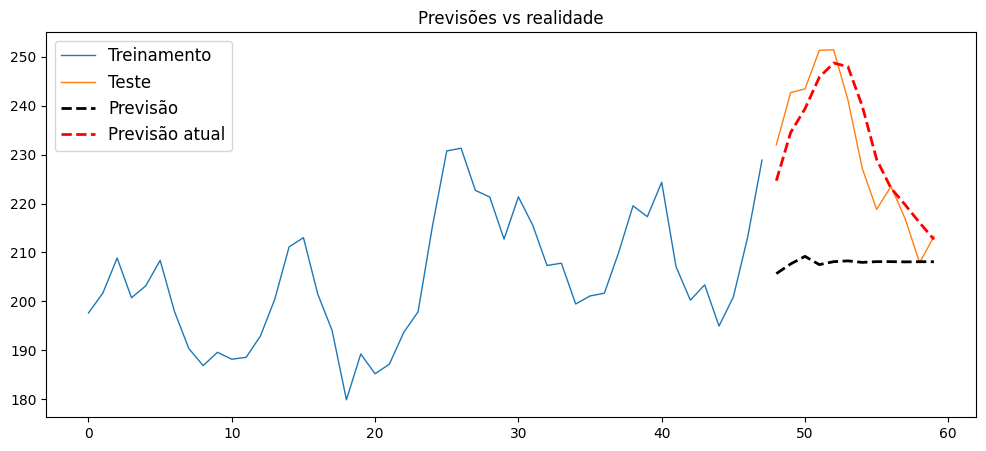

In [ ]:
plt.figure(figsize=(12,5))

plt.plot(train_ind,serie['serie_temporal'][train_ind], label='Treinamento',linestyle='solid',alpha=1,lw=1)
plt.plot(test_ind,serie['serie_temporal'][test_ind], label='Teste',linestyle='solid',alpha=1,lw=1)
plt.plot(test_ind,serie['mm3'][test_ind], label='Previsão',linestyle='dashed',alpha=1,lw=2,color='black')
plt.plot(test_ind,serie['mm3_atual'][test_ind], label='Previsão atual',linestyle='dashed',alpha=1,lw=2,color='red')

plt.title('Previsões vs realidade')
plt.legend(loc='upper left', fontsize=12)

plt.show()

## Modelos ARIMA

Os modelos Autoregressive Integrated Moving Average (ARIMA) fornecem uma abordagem para a previsão de séries temporais visando a descrever as autocorrelações nos dados.

### Ajustando um modelo ARIMA
Os modelos ARIMA permitem modelar processos chamados de não estacionários homogêneos, denotado por ARIMA(p,d,q), em $d$ indica o número de diferenças necessárias para que a série se torne estacionária, $p$ é o número total de termos defasados $(Z_{t-1}, Z_{t-2},...,Z_{t-p})$ da série que que influenciam no instante $t$ (parte Autorregressiva (AR) do modelo), e $q$ o número total de termos defasados de erros aleatórios $(e_{t-1}, e_{t-2},...,e_{t-q})$ correspondente à parte de Médias móveis (MA), sua interpretação é menos intuitiva.

### Passos para ajustar um modelo ARIMA

<img src="https://github.com/Rogerio-mack/Temporal/raw/main/Figures/Fluxograma2.png" width=500 align="middle">



1. Verificar se a série é estacionária. Um procedimento simples consiste em plotar os valores observados da série ao longo do tempo e verificar se há tendências ou sazonalidades (comportamentos de séries não estacionárias). Quando visualmente não é possível determinar se a série é ou não estacionária pode-se aplicar o teste ADF (como visto na aula anterior). Para eliminar tendências e tornar a série estacionária podem-se aplicar d diferenças (ou em alguns casos, ajustar retas de tendências por meio de polinômios)

2. Com a série estacionária, após d diferenças, selecionam-se possíveis valores de p e q com ajuda das funções ACF e PACF amostrais.

3. Ajustam-se modelos ARIMA(p,d,q) com os valores de p, d e q definidos nos dois passos anteriores.

4. Para selecionar o melhor modelo, isto é, aquele que se ajusta melhor aos dados pode-se usar, por exemplo, o critério de seleção AIC. Aquele modelo que apresentar o menor valor para este critério deve ser considerado.

5. Analisar os resíduos do modelo selecionado no passo 4. Deve-se verificar que os resíduos sejam independentes (não correlacionados), com média zero e variância constante. Vocês podem usar um gráfico de ACF e de linhas para checar estes pressupostos. Por fim, os resíduos devem seguir uma distribuição normal, pressuposto necessário para realizar previsões e construir intervalos de confiança. Aqui podem ser implementados histogramas e/ou gráficos QQ-plot.


$$\underbrace{\Delta^d Z_t}_\text{Série após d diferenças} =\mu+ \underbrace{\phi_1 \Delta^dZ_{t-1}+ \phi_2\Delta^dZ_{t-2}+...+\phi_p\Delta^d Z_{t-p}}_\text {Autorregressiva (AR)} + e_t + \underbrace{\theta_1e_{t-1}+ \theta_2 e_{t-2}+...+ \theta_q e_{t-q}}_\text{Médias móveis (MA)}, $$

em que $\phi_1,...,\phi_p, \theta_1,...,\theta_q$ são valores a serem estimados. Geralmente $e_t \sim N (0,\sigma^2)$.

Agora, vamos aplicar o modelo ARIMA nos dados de demanda. Vamos usar o pacote Autoarima para definir o melhor modelo.


In [ ]:
!pip install pmdarima

import pmdarima as pm
model_auto = pm.auto_arima(serie['serie_temporal'][train_ind], d=1,information_criterion="aic",trace=1,stepwise=False)
print(model_auto.summary())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.4 MB/s eta 0:00:00
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=334.324, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=334.386, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=335.609, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=337.387, Time=0.07 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=334.126, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=336.098, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=337.581, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=336.061, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=338.025, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept

# Previsões

In [ ]:
# Previsoes longas

model = ARIMA(serie['serie_temporal'][train_ind], order=(4, 1, 0))

# Fazendo previsões
serie['arima'] = np.nan
serie['arima'][test_ind] = model.fit().get_forecast(12).predicted_mean

serie.tail(12)

,data,serie_temporal,exog,mm3,mm3_atual,arima
48,2024-01-31,232.020825,28.088544,205.675306,224.677003,235.474388
49,2024-02-29,242.708539,29.162857,207.653256,234.539332,235.301573
50,2024-03-31,243.448920,29.432240,209.208725,239.392761,230.734793
51,2024-04-30,251.350268,30.588865,207.512429,245.835909,224.064669
52,2024-05-31,251.461379,30.632811,208.124803,248.753523,220.162611
53,2024-06-30,241.168332,29.959645,208.281986,247.993327,219.185511
54,2024-07-31,227.165349,25.953775,207.973073,239.931687,220.616450
55,2024-08-31,218.808729,25.885237,208.126621,229.047470,223.318126
56,2024-09-30,223.514310,27.605160,208.127226,223.162796,225.346311
57,2024-10-31,216.837710,27.376560,208.075640,219.720250,226.210827


In [ ]:
# Previsõe curtas

serie['arima_atual'] = np.nan

for ii in test_ind:
  model = ARIMA(serie['serie_temporal'][0:ii],order=(4,1,0))
  model_fit = model.fit()
  forecast = model_fit.get_forecast(1)
  serie['arima_atual'][ii] = forecast.predicted_mean

serie.tail(12)

,data,serie_temporal,exog,mm3,mm3_atual,arima,arima_atual
48,2024-01-31,232.020825,28.088544,205.675306,224.677003,235.474388,235.474388
49,2024-02-29,242.708539,29.162857,207.653256,234.539332,235.301573,230.944979
50,2024-03-31,243.448920,29.432240,209.208725,239.392761,230.734793,240.646205
51,2024-04-30,251.350268,30.588865,207.512429,245.835909,224.064669,239.866885
52,2024-05-31,251.461379,30.632811,208.124803,248.753523,220.162611,251.848987
53,2024-06-30,241.168332,29.959645,208.281986,247.993327,219.185511,249.882162
54,2024-07-31,227.165349,25.953775,207.973073,239.931687,220.616450,238.901275
55,2024-08-31,218.808729,25.885237,208.126621,229.047470,223.318126,220.470575
56,2024-09-30,223.514310,27.605160,208.127226,223.162796,225.346311,215.503951
57,2024-10-31,216.837710,27.376560,208.075640,219.720250,226.210827,227.442356


In [ ]:
# Previsões futuras
forecast_accuracy(serie['serie_temporal'][test_ind], serie['arima'][test_ind])

{'mape': 0.05801693665151133,
 'mae': 13.00074626642161,
 'rmse': 15.939472868033155}

In [ ]:
# Previsões atuais
forecast_accuracy(serie['serie_temporal'][test_ind], serie['arima_atual'][test_ind])

{'mape': 0.03230059303082264,
 'mae': 7.42069017889587,
 'rmse': 8.511503449441868}

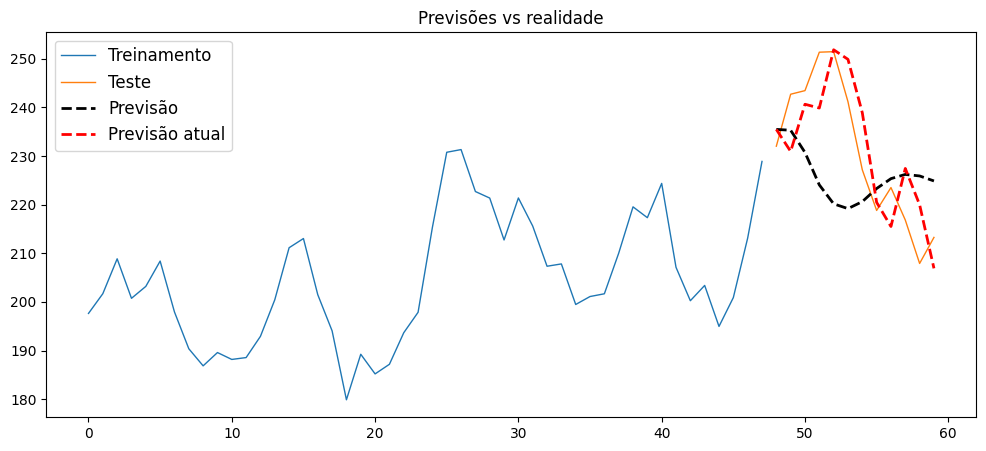

In [ ]:
plt.figure(figsize=(12,5))

plt.plot(train_ind,serie['serie_temporal'][train_ind], label='Treinamento',linestyle='solid',alpha=1,lw=1)
plt.plot(test_ind,serie['serie_temporal'][test_ind], label='Teste',linestyle='solid',alpha=1,lw=1)
plt.plot(test_ind,serie['arima'][test_ind], label='Previsão',linestyle='dashed',alpha=1,lw=2,color='black')
plt.plot(test_ind,serie['arima_atual'][test_ind], label='Previsão atual',linestyle='dashed',alpha=1,lw=2,color='red')

plt.title('Previsões vs realidade')
plt.legend(loc='upper left', fontsize=12)

plt.show()

# ARIMAX

O modelo ARIMAX consiste no modelo ARIMA com a inclusão de variáveis exógenas. Sejam $X_1, X_2, \ldots, X_n$ um conjunto de $n$ variáveis exógenas. O modelo ARIMAX é dado por

$$\underbrace{\Delta^d Z_t}_\text{Série após d diferenças} =\mu+ \underbrace{\phi_1 \Delta^dZ_{t-1}+ \phi_2\Delta^dZ_{t-2}+...+\phi_p\Delta^d Z_{t-p}}_\text {Autorregressiva (AR)} + e_t + \underbrace{\theta_1e_{t-1}+ \theta_2 e_{t-2}+...+ \theta_q e_{t-q}}_\text{Médias móveis (MA)} + \underbrace{\beta_1x_{1,t}+ \beta_2 x_{2,t}+...+ \beta_n x_{n,t}}_\text{Variável exógena}, $$

em que $\phi_1,...,\phi_p, \theta_1,...,\theta_q, \beta_1,...,\beta_n$ são valores a serem estimados. Geralmente $e_t \sim N (0,\sigma^2)$.

Dessa forma, conseguimos incluir no modelo variáveis externas que podem contribuir na previsão da demanda. Variáveis, estas, diferente de apenas o componente temporal.

Veja nos códigos abaixo como fica a implementação em Python. Note que o ARIMAX pertence ao pacote do ARIMA. A diferença é que indicamos a presença das variáveis exógenas.

In [ ]:
# Definindo o modelo ARIMAX (usando os mesmos parãmetros do modelo ARIMA obtidos anteriormente)
model = ARIMA(serie['serie_temporal'][train_ind], order=(4, 1, 0), exog=serie['exog'][train_ind])

# Treinar o modelo
model_fit = model.fit()

# Exibir o resumo do modelo
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         serie_temporal   No. Observations:                   48
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -131.725
Date:                Tue, 19 Nov 2024   AIC                            275.450
Time:                        23:07:17   BIC                            286.551
Sample:                             0   HQIC                           279.628
                                 - 48                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
exog           3.2531      0.333      9.778      0.000       2.601       3.905
ar.L1          0.4266      0.159      2.675      0.007       0.114       0.739
ar.L2          0.1919      0.214      0.895      0.3

# Previsões

In [ ]:
# Previsoes longas

serie['arimax'] = np.nan
serie['arimax'][test_ind] = model.fit().forecast(steps=12,exog=serie['exog'][test_ind])

serie.tail(12)

,data,serie_temporal,exog,mm3,mm3_atual,arima,arima_atual,arimax
48,2024-01-31,232.020825,28.088544,205.675306,224.677003,235.474388,235.474388,229.403844
49,2024-02-29,242.708539,29.162857,207.653256,234.539332,235.301573,230.944979,237.846280
50,2024-03-31,243.448920,29.432240,209.208725,239.392761,230.734793,240.646205,239.849258
51,2024-04-30,251.350268,30.588865,207.512429,245.835909,224.064669,239.866885,243.750371
52,2024-05-31,251.461379,30.632811,208.124803,248.753523,220.162611,251.848987,242.608180
53,2024-06-30,241.168332,29.959645,208.281986,247.993327,219.185511,249.882162,237.466508
54,2024-07-31,227.165349,25.953775,207.973073,239.931687,220.616450,238.901275,222.367810
55,2024-08-31,218.808729,25.885237,208.126621,229.047470,223.318126,220.470575,220.540178
56,2024-09-30,223.514310,27.605160,208.127226,223.162796,225.346311,215.503951,225.506938
57,2024-10-31,216.837710,27.376560,208.075640,219.720250,226.210827,227.442356,225.543578


In [ ]:
# Previsõe curtas

serie['arimax_atual'] = np.nan

for ii in test_ind:
  model = ARIMA(serie['serie_temporal'][0:ii],order=(4,1,0), exog=serie['exog'][0:ii])
  model_fit = model.fit()
  forecast = model_fit.forecast(steps=1,exog=serie['exog'][ii])
  serie['arimax_atual'][ii] = forecast

serie.tail(12)

,data,serie_temporal,exog,mm3,mm3_atual,arima,arima_atual,arimax,arimax_atual
48,2024-01-31,232.020825,28.088544,205.675306,224.677003,235.474388,235.474388,229.403844,229.403844
49,2024-02-29,242.708539,29.162857,207.653256,234.539332,235.301573,230.944979,237.846280,241.494386
50,2024-03-31,243.448920,29.432240,209.208725,239.392761,230.734793,240.646205,239.849258,246.199424
51,2024-04-30,251.350268,30.588865,207.512429,245.835909,224.064669,239.866885,243.750371,247.277954
52,2024-05-31,251.461379,30.632811,208.124803,248.753523,220.162611,251.848987,242.608180,250.276460
53,2024-06-30,241.168332,29.959645,208.281986,247.993327,219.185511,249.882162,237.466508,246.295433
54,2024-07-31,227.165349,25.953775,207.973073,239.931687,220.616450,238.901275,222.367810,225.508002
55,2024-08-31,218.808729,25.885237,208.126621,229.047470,223.318126,220.470575,220.540178,222.408700
56,2024-09-30,223.514310,27.605160,208.127226,223.162796,225.346311,215.503951,225.506938,219.823201
57,2024-10-31,216.837710,27.376560,208.075640,219.720250,226.210827,227.442356,225.543578,225.111471


In [ ]:
# Previsões futuras
forecast_accuracy(serie['serie_temporal'][test_ind], serie['arimax'][test_ind])

{'mape': 0.01883423233762262,
 'mae': 4.3730049884891855,
 'rmse': 5.064232308145649}

In [ ]:
# Previsões atuais
forecast_accuracy(serie['serie_temporal'][test_ind], serie['arimax_atual'][test_ind])

{'mape': 0.016710508702242395,
 'mae': 3.745467610307626,
 'rmse': 4.563863677072729}

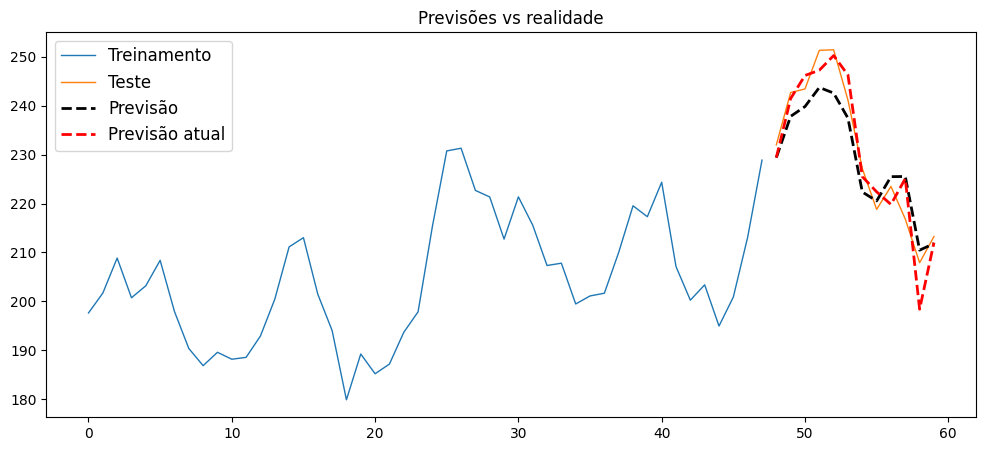

In [ ]:
plt.figure(figsize=(12,5))

plt.plot(train_ind,serie['serie_temporal'][train_ind], label='Treinamento',linestyle='solid',alpha=1,lw=1)
plt.plot(test_ind,serie['serie_temporal'][test_ind], label='Teste',linestyle='solid',alpha=1,lw=1)
plt.plot(test_ind,serie['arimax'][test_ind], label='Previsão',linestyle='dashed',alpha=1,lw=2,color='black')
plt.plot(test_ind,serie['arimax_atual'][test_ind], label='Previsão atual',linestyle='dashed',alpha=1,lw=2,color='red')

plt.title('Previsões vs realidade')
plt.legend(loc='upper left', fontsize=12)

plt.show()